# Train

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.datasets.datasets import LSTMDataset, get_dataset
from hython.trainer import train_val
from hython.sampler import SamplerBuilder, RegularIntervalDownsampler
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer


import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
ERROR 1: PROJ: proj_create_from_database: Open of /home/iferrario/.local/miniforge/envs/emulator/share/proj failed


# Settings

In [33]:
# PARAMETERS 

EXPERIMENT  = "test"

SURROGATE_INPUT = "https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_preprocessed.zarr/"

SURROGATE_MODEL_OUTPUT = f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/{EXPERIMENT}.pt"
TMP_STATS = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats"

# === FILTER ==============================================================

# train/test temporal range
train_temporal_range = slice("2015-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

# variables
dynamic_names = ["precip", "pet", "temp"] 
static_names = [ "wflow_dem", "Slope", "wflow_uparea"]  #[ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "runoff_river"]

# === MASK ========================================================================================

mask_names = ["mask_missing", "mask_lake"] # names depends on preprocessing application

# === DATASET ========================================================================================

DATASET = "LSTMDataset" # "XBatchDataset"

# == MODEL  ========================================================================================

HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)
TARGET_WEIGHTS = {t:1/len(target_names) for t in target_names}


# === SAMPLER/TRAINER ===================================================================================

# downsampling
DONWSAMPLING = True


SEED = 42
EPOCHS = 50
BATCH = 256

TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 30


assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"



In [34]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
# === READ TRAIN ===================================================================
Xd = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(url=SURROGATE_INPUT , group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=SURROGATE_INPUT , group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]

# === READ TEST ===================================================================

Y_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="y", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .y.sel(feat=target_names)
)
Xd_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .xd.sel(feat=dynamic_names)
)

In [36]:
masks = (
    read_from_zarr(url=SURROGATE_INPUT, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

In [37]:
# viz input
#Xd.unstack().isel(time=199).sel(feat="temp").plot()

In [38]:
if DONWSAMPLING:
   train_downsampler = RegularIntervalDownsampler(
        intervals=[4,4], origin=[0,0]
    )       
   test_downsampler = RegularIntervalDownsampler(
        intervals=[4,4], origin=[2,2]
    )
else:
    train_downsampler,test_downsampler = None,None

In [39]:
# === NORMALIZE ======================================================================

normalizer_dynamic = Normalizer(method="standardize", type="spacetime", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_xd.npy")
normalizer_static = Normalizer(method="standardize", type="space", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_xs.npy")
normalizer_target = Normalizer(method="standardize", type="spacetime", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_y.npy")


In [40]:
# === DATSET =======================================================================

train_dataset = get_dataset(DATASET)(
        Xd,
        Y,
        Xs,
        original_domain_shape=SHAPE,
        mask = masks,
        downsampler = train_downsampler,
        normalizer_dynamic = normalizer_dynamic,
        normalizer_static = normalizer_static,
        normalizer_target = normalizer_target
)
test_dataset = get_dataset(DATASET)(
        Xd_test,
        Y_test,
        Xs,
        original_domain_shape=SHAPE,
        mask = masks,
        downsampler = test_downsampler,
        normalizer_dynamic = normalizer_dynamic,
        normalizer_static = normalizer_static,
        normalizer_target = normalizer_target
)

[    0     1     2 ... 40137 40138 40139]
compute stats
write stats to /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/test_xd.npy
compute stats
write stats to /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/test_xs.npy
compute stats
write stats to /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/test_y.npy
[    0     1     2 ... 40137 40138 40139]


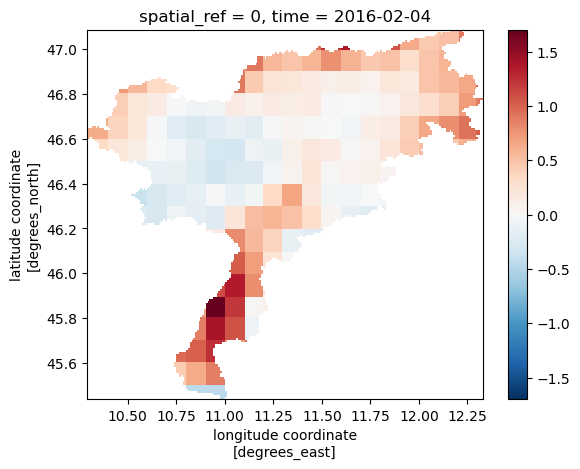

In [42]:
# viz torch datasets
from hython.utils import reshape_to_2Dspatial, to_xr
coords = read_from_zarr("https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_original.zarr/", group="xd").sel(time=train_temporal_range).coords
to_xr(reshape_to_2Dspatial(np.array(train_dataset.xd), *SHAPE, Xd.shape[1], Xd.shape[-1])[...,0], coords=coords).isel(time=399).plot()

In [43]:
# === SAMPLER ===================================================================


train_sampler_builder = SamplerBuilder(
    train_dataset,
    sampling="random", 
    processing="single-gpu")

test_sampler_builder = SamplerBuilder(
    test_dataset,
    sampling="sequential", 
    processing="single-gpu")


train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

In [44]:
# === DATA LOADER ================================================================

train_loader = DataLoader(train_dataset, batch_size=BATCH , sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [45]:
# === MODEL ===================================================================

model = CuDNNLSTM(
                hidden_size=HIDDEN_SIZE, 
                dynamic_input_size=DYNAMIC_INPUT_SIZE,
                static_input_size=STATIC_INPUT_SIZE, 
                output_size=OUTPUT_SIZE
)

model.to(device)


CuDNNLSTM(
  (fc0): Linear(in_features=6, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=1, bias=True)
)

In [46]:
# === TRAIN ===================================================================
    
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

trainer = RNNTrainer(
    RNNTrainParams(
            experiment=EXPERIMENT,
            temporal_subsampling=TEMPORAL_SUBSAMPLING, 
            temporal_subset=TEMPORAL_SUBSET, 
            seq_length=SEQ_LENGTH, 
            target_names=target_names,
            metric_func=metric_fn,
            loss_func=loss_fn)
)

In [47]:
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    test_loader,
    EPOCHS,
    opt,
    lr_scheduler,
    SURROGATE_MODEL_OUTPUT,
    device
)


  0%|          | 0/50 [00:00<?, ?it/s]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.2802068889141083
val loss: 0.3795246481895447
train loss: 0.23060886561870575
val loss: 0.3857898712158203
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.2564986050128937
val loss: 0.26521244645118713
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.2312145233154297
val loss: 0.2630177438259125
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.190021812915802
val loss: 0.2301751673221588
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.14144881069660187
val loss: 0.2127600908279419
train loss: 0.17240577936172485
val loss: 0.309397429227829
train loss: 0

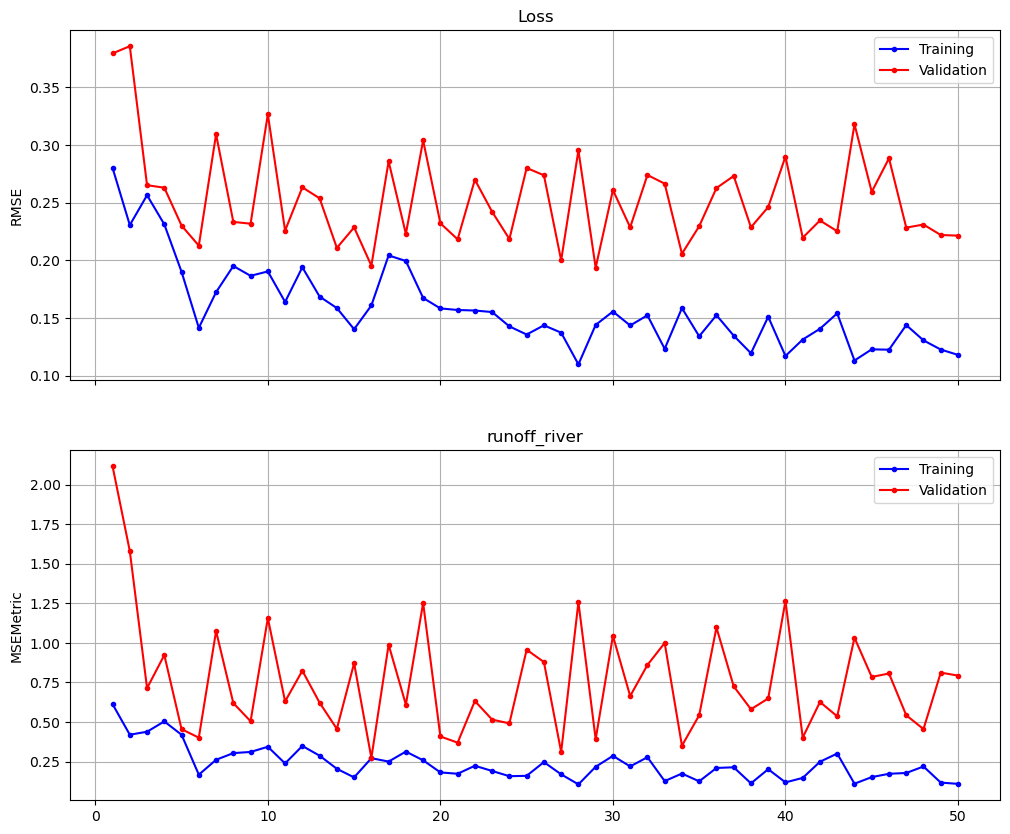

In [48]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(len(target_names) +1, 1, figsize= (12,10), sharex=True)

axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('Loss')
axs[0].set_ylabel(loss_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

for i, variable in enumerate(target_names):
    axs[i+1].plot(lepochs, metric_history[f'train_{variable}'], marker='.', linestyle='-', color='b', label='Training')
    axs[i+1].plot(lepochs, metric_history[f'val_{variable}'], marker='.', linestyle='-', color='r', label='Validation')
    axs[i+1].set_title(variable)
    axs[i+1].set_ylabel(metric_fn.__class__.__name__)
    axs[i+1].grid(True)
    axs[i+1].legend(bbox_to_anchor=(1,1))